# Dynamics of an elastic beam: explicit time integration
In this notebook, we investigate the dynamics of an elastic beam using a linear and a nonlinear model. The beam is subjected to an external traction $\sigma_{ext}$ at one of its two ends over a short time period. We compute the dynamics of the beam using an explicit time-stepping scheme.


![shema](setup_dynamics.png)

In [1]:
import dolfinx
import dolfinx.fem as fem
import numpy as np
import matplotlib.pyplot as plt
import ufl
import time
from mpi4py import MPI
from petsc4py.PETSc import ScalarType
import dolfinx.fem.petsc
import pyvista
import utils

### Definition of the geometry and the mesh

We consider a cantilever beam of size `L × d` (2D, plane stress), fixed at its `x = 0` end, and subjected to an axial or transverse load at `x = L`. 

In [2]:
# geometry and mesh 
L = 1.0 # total length
d = 0.1*L # thickness
h = 0.2*d # size of a cell

my_domain = dolfinx.mesh.create_rectangle(comm=MPI.COMM_WORLD,
                            points=((0.0, -0.5*d), (L, 0.5*d)), n=(int(L/h), int(d/h)),
                            cell_type=dolfinx.mesh.CellType.triangle)

# Save the mesh in XDMF format
with dolfinx.io.XDMFFile(MPI.COMM_WORLD, "output_dyn_expl/mesh.xdmf", "w") as file:
    file.write_mesh(my_domain)
    my_domain.topology.create_connectivity(1, 2)

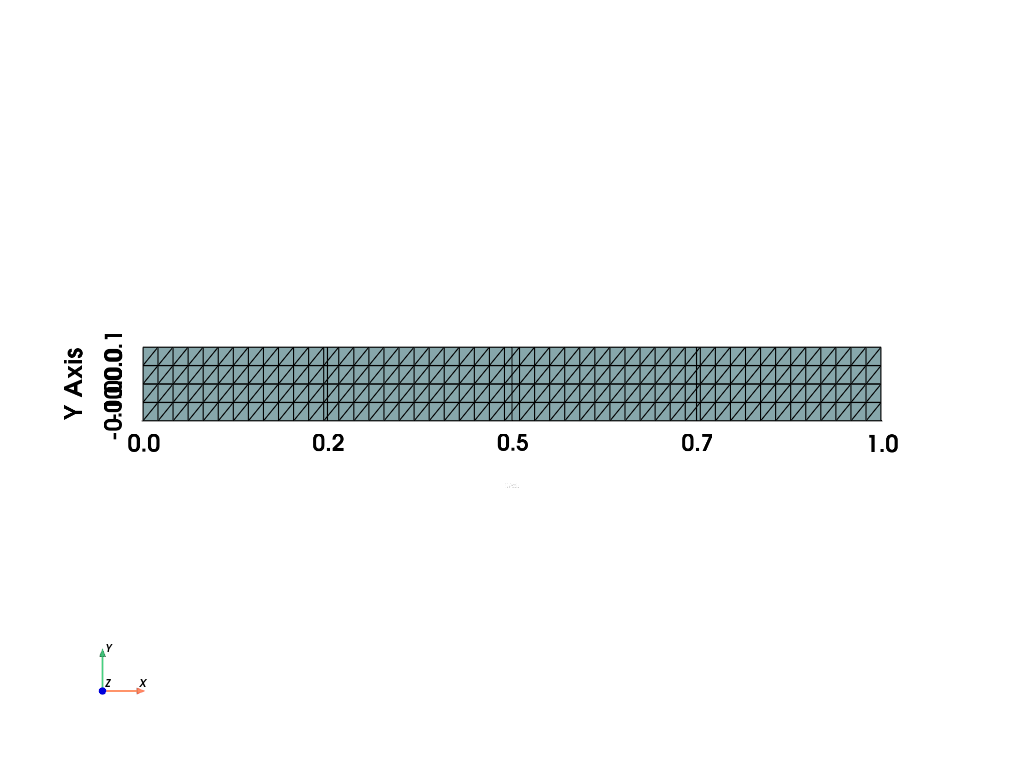

In [3]:
pyvista.start_xvfb()
pyvista.set_jupyter_backend("static") # non-interactif, mais mieux
topology, cell_types, geometry_for_plotting = dolfinx.plot.vtk_mesh(my_domain, 2)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry_for_plotting)

plotter = pyvista.Plotter()
plotter.add_mesh(grid, show_edges=True)
plotter.show_axes()
plotter.show_bounds(grid='front', location='outer', all_edges=True)
plotter.view_xy()

if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    pyvista.start_xvfb()
    figure = plotter.screenshot("fundamentals_mesh.png")

In [4]:
# Define the different parts of the boundary
boundaries = [(1, lambda x: np.isclose(x[0], 0)),
              (2, lambda x: np.isclose(x[0], L)),
              (3, lambda x: np.isclose(x[1], -0.5*d)),
              (4, lambda x: np.isclose(x[1], 0.5*d))]

facet_indices, facet_markers = [], []
fdim = my_domain.topology.dim - 1
for (marker, locator) in boundaries:
    facets = dolfinx.mesh.locate_entities(my_domain, fdim, locator)
    facet_indices.append(facets) # here we put all the facets indices
    facet_markers.append(np.full_like(facets, marker)) # here we put all the facets 'labels' (1, 2, 3 or 4)
facet_indices = np.hstack(facet_indices).astype(np.int32) # concatenate everything in one big vector
facet_markers = np.hstack(facet_markers).astype(np.int32)
sorted_facets = np.argsort(facet_indices) # sorting
facet_tag = dolfinx.mesh.meshtags(my_domain, fdim, facet_indices[sorted_facets], facet_markers[sorted_facets])

In [5]:
ds = ufl.Measure("ds", domain=my_domain, subdomain_data=facet_tag)
dx = ufl.dx(domain=my_domain)

### Material parameters

In [6]:
# Material parameters
Y  = 1.
nu = 0.3
mu = Y/(2.*(1.+nu))
lambda_ = Y*nu/((1.+nu)*(1.-2.*nu))
# lambda_ = 2*lambda_*mu/(lambda_+2*mu) # plane stress
rho = dolfinx.fem.Constant(my_domain,ScalarType(1.))

# Damping parameters
# The damping matrix C is defined as C = eta_m*M+eta_k*K
eta_m = dolfinx.fem.Constant(my_domain,ScalarType(0.01))
eta_k = dolfinx.fem.Constant(my_domain,ScalarType(0.00001))

### Definition of the problem in the linear and in the nonlinear case (finite deformations)

In [7]:
V = fem.functionspace(my_domain, ("Lagrange", 1, (my_domain.geometry.dim, )))

In [8]:
boundary_clamped_dofs = dolfinx.fem.locate_dofs_topological(V, facet_tag.dim, facet_tag.find(1)) # dofs on the left end of the bar

#this is the boundary value of u(x,y) at the left border : it has to be zero (clamped)
u_D = np.array([0,0], dtype=ScalarType)

bc = dolfinx.fem.dirichletbc(u_D, boundary_clamped_dofs, V)

In [9]:
I2 = ufl.Identity(my_domain.topology.dim)
# Kinematics
def strain_displacement(u):
    return ufl.sym(ufl.grad(u))

def stress_linear(eps):
    return lambda_*ufl.tr(eps)*I2+2.*mu*eps

def stiffness_linear(u, v):
    return ufl.inner(stress_linear(strain_displacement(u)),strain_displacement(v))*dx  

In [10]:
traction = dolfinx.fem.Constant(my_domain, ScalarType((0,0)))

def mass(u, v):
    return rho*ufl.inner(u, v)*dx

def damping(u, v):
    return eta_m*mass(u, v) + eta_k*stiffness_linear(u, v)

def p_ext(u):
    return ufl.dot(traction,u)*ds(2) # traction is applied at right end of bar

In [11]:
u = ufl.TrialFunction(V)
u_bar = ufl.TestFunction(V)

In [12]:
# Lumped mass matrix
ones = dolfinx.fem.Function(V)
ones.x.array[:] = 1.
M_lumped_inv = dolfinx.fem.petsc.assemble_vector(dolfinx.fem.form(ufl.action(mass(u,u_bar), ones)))
M_lumped_inv.array[:] = 1./M_lumped_inv.array[:]

In [13]:
u_sol = dolfinx.fem.Function(V)# displacement of the solution
v_sol = dolfinx.fem.Function(V)# velocity of the solution
a_sol = dolfinx.fem.Function(V)# acceleration of the solution

In [14]:
# We compute the strain tensor of the solution
eps_solution = strain_displacement(u_sol)
V_eps = dolfinx.fem.functionspace(my_domain,("DG", 0))
eps_xx_expr = dolfinx.fem.Expression(eps_solution[0,0], V_eps.element.interpolation_points())
eps_xx = dolfinx.fem.Function(V_eps)

### Parameters of the simulation

#### Material, loading and time-discretization parameters

A time-dependent traction is applied at the $x = L$ face as follows
\begin{equation}
\sigma_{ext} = \begin{cases}
\displaystyle\frac{t}{t_{\mathrm{c}}}  \sigma_{\mathrm{max}} & t \leq t_{\mathrm{c}}\\[.2em]
0 & t > t_{\mathrm{c}}
\end{cases}
\end{equation}
where $t_{\mathrm{c}}$ is a “cut-off” time. Note that depending on the direction of the applied traction, we will need to select different values for `t_c` and `T_max`.

In [15]:
# Here are some parameters that could be changed

use_lumped_mass = True # True if we use a lumped mass matrix, False for the usual mass matrix

# Loading
t_end = 7. # end time of the simulation
num_steps  = 7000 # total number of steps for the entire simulation
dt = t_end/num_steps

t_cutoff = 2.0 # time duration for which we pull on the bar, this t_c
sigma_max = 0.05 # sigma_max

# Coordinates of the plotting point 
coords_tip = [L,0]

### Explicit time-stepping scheme

![shema](time_steping.png)

In [16]:
u_sol.x.array[:] = 0.
v_sol.x.array[:] = 0.
a_sol.x.array[:] = 0.

times = dt*np.arange(num_steps+1, dtype=np.float64)
displ_tip = np.zeros_like(times)
extension_strain = 0.0*times 
# what is the difference between np.zeros_like(times) and 0.0*times?

energies = np.zeros((num_steps+1, 4), dtype=np.float64)
E_damp = 0
E_elas = 0
E_ext = 0

f_load = p_ext(u_bar) - stiffness_linear(u_sol,u_bar) -  damping(v_sol,u_bar)# why these minus signs?

problem = dolfinx.fem.petsc.LinearProblem(mass(u,u_bar), f_load, bcs=[bc], 
                                          petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
def load_eval(t):
    if t <= t_cutoff:
        return sigma_max*t/t_cutoff
    else:
        return 0
    
with dolfinx.io.XDMFFile(my_domain.comm, "output_dyn_expl/time_steps_u.xdmf", "w") as file:
    file.write_mesh(my_domain)

time_solve = 0.
for n in range(num_steps):
    if (n%500 == 0): # we print() every 500 steps
        print(n,' / ', num_steps)
        
    traction.value = (load_eval((n+1)*dt),0) # along e_x

    t1 = time.perf_counter()
    if use_lumped_mass:
        af = dolfinx.fem.petsc.assemble_vector(dolfinx.fem.form(f_load))
        a_sol.x.array[:] = np.multiply(M_lumped_inv,af.array[:])
        dolfinx.fem.set_bc(u_sol.vector, [bc])
        dolfinx.fem.set_bc(v_sol.vector, [bc])
        dolfinx.fem.set_bc(a_sol.vector, [bc])
    else:
        a_sol = problem.solve()

    t2 = time.perf_counter()
    time_solve += t2-t1
    
# Corrector step   
    v_sol.vector.axpy(dt, a_sol.vector) # what does axpy() do?
    u_sol.vector.axpy(dt, v_sol.vector)
    
    if (n%10 == 0):
        with dolfinx.io.XDMFFile(my_domain.comm, "output_dyn_expl/time_steps_u.xdmf", "a") as file:
            file.write_function(u_sol, (n+1)*dt)
    
    eps_xx.interpolate(eps_xx_expr)
    extension_strain[n+1] = utils.evaluate_at_points(np.array([[0.5*L], [0.25*d], [0]]), eps_xx)[0,0]
    displ_tip[n+1] = utils.evaluate_at_points(np.array([[coords_tip[0]], [coords_tip[1]], [0]]), u_sol)[0,0]
    
    E_elas = dolfinx.fem.assemble_scalar(dolfinx.fem.form(0.5*stiffness_linear(u_sol, u_sol)))
    E_kin = dolfinx.fem.assemble_scalar(dolfinx.fem.form(0.5*mass(v_sol, v_sol)))
    E_damp += dt*dolfinx.fem.assemble_scalar(dolfinx.fem.form(damping(v_sol, v_sol)))
    E_tot = E_elas+E_kin+E_damp
    energies[n+1, :] = np.array([E_elas, E_kin, E_damp, E_tot])
    
print('Total time for Lin. Alg. solving:',time_solve)

0  /  7000
500  /  7000
1000  /  7000
1500  /  7000
2000  /  7000
2500  /  7000
3000  /  7000
3500  /  7000
4000  /  7000
4500  /  7000
5000  /  7000
5500  /  7000
6000  /  7000
6500  /  7000
Total time for Lin. Alg. solving: 6.269368017002762


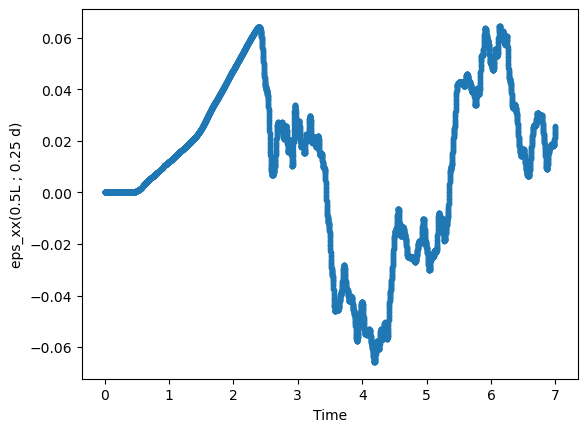

In [17]:
plt.plot(times, extension_strain, '.-')
plt.xlabel("Time")
plt.ylabel("eps_xx(0.5L ; 0.25 d)")
plt.show()

Text(0, 0.5, 'Tip displacement')

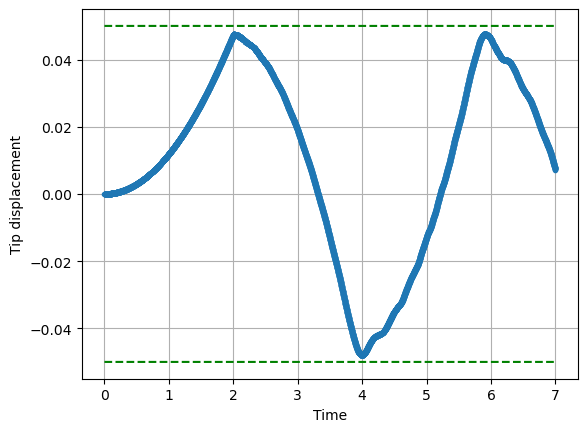

In [18]:
plt.figure()
plt.plot(times, displ_tip, '.-')
plt.plot(times, sigma_max*L/Y*np.ones_like(times), '--g') # what is this limit?
plt.plot(times, -sigma_max*L/Y*np.ones_like(times), '--g') # what is this limit?
plt.grid()
plt.xlabel("Time")
plt.ylabel("Tip displacement")
#plt.savefig("tip_displacement.png")

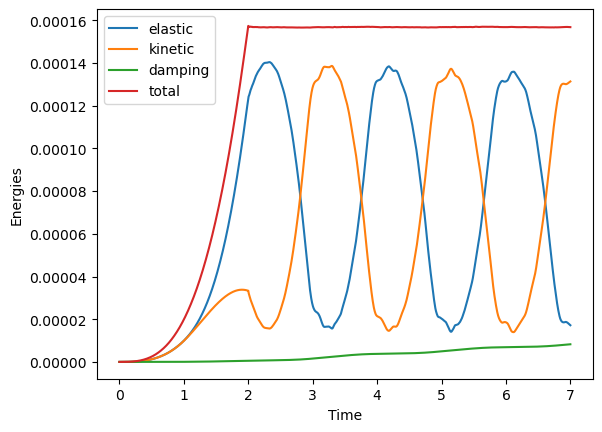

In [19]:
plt.figure()
plt.plot(times, energies)
plt.legend(("elastic", "kinetic", "damping", "total"))
plt.xlabel("Time")
plt.ylabel("Energies")
plt.show()

In [20]:
rmin = 0.3*h # estimate of the radius of the circle inscribed in the triangles
dt_crit = rmin/np.sqrt(Y/rho.value)
print("Critical time step {:.2e}s".format(dt_crit))
print("Used time step {:.2e}s".format(dt))

Critical time step 6.00e-03s
Used time step 1.00e-03s


# Exercise

**y)** Why did we choose $L=1$, $Y=1$, $\rho=1$? Is there a loss of generality?

**z)** Does the present system exhibit a periodic behavior? If yes, what is the period? The period for the extension-compression vibration of a 1D beam is $T = k_{ext} L \sqrt{\rho/Y}$. Does it correspond to what you find? What is the value of $k$?

**a)** Change the values of the damping parameters and describe how this modifies the displacement and energy plots. 

**b)** Decrease the value of the loading time t_c = t_cutoff, for example t_c=O.5 and t_c=2.0. Observe and interpret how the curves change.

**c)** Change the number of time-steps and observe what happends when $dt >dt_{crit}$, explain.

**d)** Do you observe a significant difference when you use the lumped mass matrix instead of the usual mass matrix?

**e)** How does the difference in computational time between these two approaches (lumped mass or standard mass) vary with the size of the mesh?

**f)** Does the material remain in the linear elastic regime at all times?

**g.1)** Modify the orientation of the applied traction (put it vertical). Compute u_y(L,0) for the static solution for a given $\sigma_{max}$ applied vertical load.

**g.2)** When the applied traction is vertical, is the behavior periodic? The vibration period for the bending of a 1D beam is $T_{bend}= k_{bend} \, L^2 \sqrt{\rho A / (YI)}$. Does it correspond to what you find? What is the value of $k$? (be carefull that much more steps are going to be needed)